# Подготовка датасета для экпериментального метода аугментации данных при помощи модели Stable Diffusion

Для увеличения объема примеров обнаружения объектов в датасете, предлагаем метод который при помощи модели Stable Diffusion может в значительное количество раз увеличить объем, предлагая различного рода объекты. 

Для более лучшей генерации необходимо сделать файнтюнинг модели, для этого создадим собственный датасет для файнтюнинга. Возьмем пример датасета `lambdalabs/pokemon-blip-captions`, и наш датасет `object detection` в формате `COCO` и проведем `promt engeniring` чо бы сформировать датасет для файнтюнинга `Stable Diffusion`

In [1]:
from datasets import load_dataset

In [2]:
ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = ds[0]

Using custom data configuration lambdalabs--pokemon-blip-captions-baa94796864cc987


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-baa94796864cc987/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


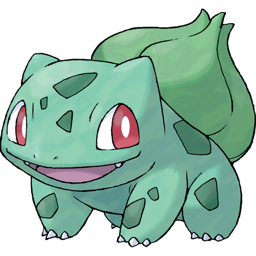

In [3]:
sample['image'].resize((256, 256))

In [4]:
sample["text"]

'a drawing of a green pokemon with red eyes'

Формат к которому необходимо привести датасет

```
{
'image':Pillow.Image,
'text':promt_text
}
```

Взглянем на наш датасет с `object detection`  в  формат COCO. И пройдемся по алгоритму создания элемента датасета для обучения StableDiffusion 

In [5]:
import random

from pycocotools.coco import COCO
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import numpy as np


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Загружаем COCO датасет

In [6]:
ann_file = '/app/dataset/WoodSurfaceDefects_COCO/train.json'
dataset_path = '/app/dataset/WoodSurfaceDefects_COCO/train'

In [7]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Смотрим какие категории у нас есть

In [8]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print(f'COCO Категории: {nms}')

COCO Категории: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


Выберем первый класс и посмотрим на изображение с разметкой

In [9]:
# catIds = coco.getCatIds(catNms=[nms[0]])
catIds = coco.getCatIds()

imgIds = coco.getImgIds(catIds=catIds)
print(f'Id изображений с выбранной категорией: {imgIds}')

Id изображений с выбранной категорией: []


Такое изображение нашлось, отобразим его и посмотрим на разметку

In [10]:
# imgId = imgIds[6]
imgId = 276

In [11]:
img = coco.loadImgs(imgId)[0]
img

{'date_captured': '2023',
 'file_name': '000000000276.jpg',
 'id': 276,
 'height': 1024,
 'width': 2800}

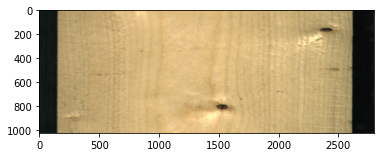

In [12]:
im = Image.open(dataset_path + '/' + img['file_name'])
plt.imshow(im)

In [13]:
img_exif = im.getexif()
print(type(img_exif))
# <class 'PIL.Image.Exif'>

if (img_exif is None) or (len(img_exif) == 0):
    print('Sorry, image has no exif data.')
else:
    for key, val in img_exif.items():
        if key in ExifTags.TAGS:
            print(f'{ExifTags.TAGS[key]}:{val}')
            # ExifVersion:b'0230'
            # ...
            # FocalLength:(2300, 100)
            # ColorSpace:1
            # ...
            # Model:'X-T2'
            # Make:'FUJIFILM'
            # LensSpecification:(18.0, 55.0, 2.8, 4.0)
            # ...
            # DateTime:'2019:12:01 21:30:07'
            # ...

<class 'PIL.Image.Exif'>
Sorry, image has no exif data.


anns=[{'segmentation': [[1477.0, 780.0, 1590.0, 780.0, 1590.0, 837.0, 1477.0, 837.0]], 'area': 6441.0, 'iscrowd': 0, 'image_id': 276, 'bbox': [1477.0, 780.0, 113.0, 57.0], 'category_id': 5, 'id': 577}, {'segmentation': [[2347.0, 136.0, 2462.0, 136.0, 2462.0, 190.0, 2347.0, 190.0]], 'area': 6210.0, 'iscrowd': 0, 'image_id': 276, 'bbox': [2347.0, 136.0, 115.0, 54.0], 'category_id': 5, 'id': 578}]


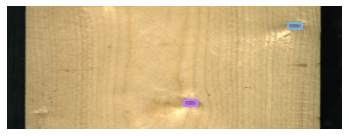

In [14]:
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(f'anns={anns}')
coco.showAnns(anns, draw_bbox=True)

Посмотрим на ббоксы

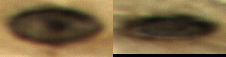

In [15]:
deffects = []
for ann in anns:
    x, y, w, h = [int(x) for x in ann['bbox']]
    im = Image.open(dataset_path + "/" + coco.loadImgs(ids=[imgId])[0]['file_name'])
    im_np = np.array(im)[y:y+h, x:x+w]
    deffects.append(Image.fromarray(im_np))
    
image_grid(deffects, 1, len(deffects))

Поскольку StableDiffusion обучается на 512х512, приведем ббоксы к формату 1:1

In [16]:
orig_w, orig_h = im.size
print(f'Исходный размер изображения: {(orig_w, orig_h)}')
# padding_w, padding_h = int(orig_w * SCALE_PADDING_PERCENT), int(orig_h * SCALE_PADDING_PERCENT)
# print(f'Отступы по ширине/высоте {(padding_w, padding_h)}')

Исходный размер изображения: (2800, 1024)


In [17]:
x, y, w, h = anns[0]['bbox']
print(f'Исходный ббокс: {(x, y, w, h)}')
center_point = (x + w // 2, y + h // 2)
print(f'Центр ббокса {center_point}')

max_side = max(w,h)
print(f'Максимальная сторона {max_side}')

delta_w, delta_h = max_side - w, max_side - h
print(f'отступ по ширине|длине = {delta_w}|{delta_h}')


new_x =  x - delta_w // 2
new_y = y - delta_h // 2

if new_x < 0:
    max_side += new_x
    new_x = 0
    
if new_y < 0:
    max_side += new_y
    new_y = 0

residual_w, residual_h = (0,0)
if new_x + max_side > orig_w:
    residual_w = new_x + max_side - orig_w
if new_y + max_side > orig_h:
    residual_h = new_y + max_side - orig_h

residual = max(residual_w, residual_h)
max_side -= residual

square_bbox = [
    new_x,
    new_y,
    max_side,
    max_side
]
print(f'квадратный ббокс = {square_bbox}')


Исходный ббокс: (1477.0, 780.0, 113.0, 57.0)
Центр ббокса (1533.0, 808.0)
Максимальная сторона 113.0
отступ по ширине|длине = 0.0|56.0
квадратный ббокс = [1477.0, 752.0, 113.0, 113.0]


In [18]:
anns

[{'segmentation': [[1477.0,
    780.0,
    1590.0,
    780.0,
    1590.0,
    837.0,
    1477.0,
    837.0]],
  'area': 6441.0,
  'iscrowd': 0,
  'image_id': 276,
  'bbox': [1477.0, 780.0, 113.0, 57.0],
  'category_id': 5,
  'id': 577},
 {'segmentation': [[2347.0,
    136.0,
    2462.0,
    136.0,
    2462.0,
    190.0,
    2347.0,
    190.0]],
  'area': 6210.0,
  'iscrowd': 0,
  'image_id': 276,
  'bbox': [2347.0, 136.0, 115.0, 54.0],
  'category_id': 5,
  'id': 578}]

In [19]:
anns[0]['bbox'] = square_bbox
anns[0]['area'] = square_bbox[2] * square_bbox[3]
anns

[{'segmentation': [[1477.0,
    780.0,
    1590.0,
    780.0,
    1590.0,
    837.0,
    1477.0,
    837.0]],
  'area': 12769.0,
  'iscrowd': 0,
  'image_id': 276,
  'bbox': [1477.0, 752.0, 113.0, 113.0],
  'category_id': 5,
  'id': 577},
 {'segmentation': [[2347.0,
    136.0,
    2462.0,
    136.0,
    2462.0,
    190.0,
    2347.0,
    190.0]],
  'area': 6210.0,
  'iscrowd': 0,
  'image_id': 276,
  'bbox': [2347.0, 136.0, 115.0, 54.0],
  'category_id': 5,
  'id': 578}]

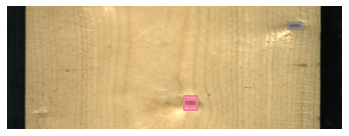

In [20]:
plt.imshow(im); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)

Поскольку StableDiffusion зависит от контекста, то увеличим область ббокса (если это возможно)

In [21]:
SCALE_PADDING_PERCENT = 0.2
square_bbox_with_padding = None
if (square_bbox[2] == orig_w or square_bbox[3] == orig_h):
    square_bbox_with_padding = square_bbox
else:
    padding = int(max_side * SCALE_PADDING_PERCENT)
    print(f'padding={padding}')
    square_bbox_with_padding = [
        square_bbox[0] - padding,
        square_bbox[1] - padding,
        square_bbox[2] + padding * 2,
        square_bbox[3] + padding * 2
    ]
    
    #Проверяем увеличенный ббокс на выход за границы изображения
    x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
    x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])
    
    # если ббокс и так большой, то нет смысла его увеличивать и оставляем как есть
    if x2 - x1 > orig_w or y2 - y1 > orig_h:
        square_bbox_with_padding = square_bbox.copy()
    else:
        new_offset_x = 0
        new_offset_y = 0

        if x2 > orig_w:
            print('x2 > orig_w')
            new_offset_x = orig_w - x2
        if y2 > orig_h:
            print('y2 > orig_h')
            new_offset_y = orig_h - y2
        if x1 < 0:
            print('x1 < 0')
            new_offset_x = -x1
        if y1 < 0:
            print('y1 < 0')
            new_offset_y = -y1


        x1 += new_offset_x
        y1 += new_offset_y

        print(x1, y1)
        print(new_offset_x, new_offset_y)

        square_bbox_with_padding[0] = x1
        square_bbox_with_padding[1] = y1

print(f'square_bbox_with_padding={square_bbox_with_padding}')

padding=22
1455.0 730.0
0 0
square_bbox_with_padding=[1455.0, 730.0, 157.0, 157.0]


In [22]:
anns[0]['bbox'] = square_bbox_with_padding
anns[0]['area'] = square_bbox_with_padding[2]*square_bbox_with_padding[3]
anns

[{'segmentation': [[1477.0,
    780.0,
    1590.0,
    780.0,
    1590.0,
    837.0,
    1477.0,
    837.0]],
  'area': 24649.0,
  'iscrowd': 0,
  'image_id': 276,
  'bbox': [1455.0, 730.0, 157.0, 157.0],
  'category_id': 5,
  'id': 577},
 {'segmentation': [[2347.0,
    136.0,
    2462.0,
    136.0,
    2462.0,
    190.0,
    2347.0,
    190.0]],
  'area': 6210.0,
  'iscrowd': 0,
  'image_id': 276,
  'bbox': [2347.0, 136.0, 115.0, 54.0],
  'category_id': 5,
  'id': 578}]

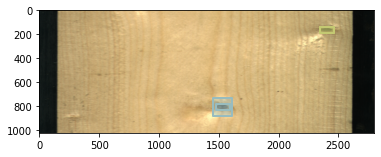

In [23]:
plt.imshow(im); plt.axis('on')
coco.showAnns(anns, draw_bbox=True)

In [33]:
anns[0]['bbox'][1]

730.0

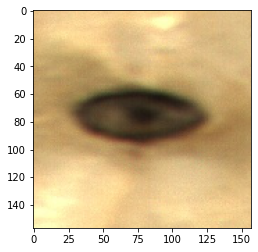

In [34]:
im_np = np.array(im)[ int(anns[0]['bbox'][1]) : int(anns[0]['bbox'][1] + anns[0]['bbox'][3]), int(anns[0]['bbox'][0]) : int(anns[0]['bbox'][0] + anns[0]['bbox'][2]) ]
curr_img = Image.fromarray(im_np)
plt.imshow(curr_img)

Далее нужно сгенерировать промпт для получившегося изображения

In [35]:
#labelid2text = {0:'crack', 1:'fistula', 2:'rupture'} # Конвертация id класса в название Quartzity, Live_Knot, Marrow, resin, Dead_Knot, knot_with_crack, Knot_missing and Crack.
labelid2text = {1:'Quartzity', 2:'Live_Knot', 3:'Marrow', 4:'resin', 5:'Dead_Knot', 6:'knot_with_crack', 7:'Knot_missing', 8:'Crack'} 
# PROMT_TEMAPLTE = [
#     'photo of a <OBJ> on a metal pipe',
#     '<OBJ> on a metal pipe',
#     '<OBJ> on a old metal pipe',
#     'corrosion <OBJ> on a metal pipe',
#     'corrosion <OBJ> on a old metal pipe',
#     '<OBJ> on a rusty metal pipe'
# ]

PROMT_TEMAPLTE = [
    '<OBJ> on a wooden surface'
]

def generate_promt(obj:str):
    return random.choice(PROMT_TEMAPLTE).replace('<OBJ>', obj)

In [36]:
test_dataset = []

generated_promt = generate_promt(labelid2text[anns[0]['category_id']])

test_dataset.append({
    'text': generated_promt,
    'image': curr_img
})

In [37]:
test_dataset

[{'text': 'Dead_Knot on a wooden surface',
  'image': <PIL.Image.Image image mode=RGB size=157x157 at 0x7F64026BB690>}]

# Создание Датасета для файнтюнинга

In [1]:
from pycocotools.coco import COCO
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

In [2]:
ann_file = '/app/dataset/WoodSurfaceDefects_COCO/train.json'
dataset_path = '/app/dataset/WoodSurfaceDefects_COCO/train'

In [3]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [4]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO Категории: \n{}'.format(' '.join(nms)))

COCO Категории: 
Quartzity Live_Knot Marrow resin Dead_Knot knot_with_crack Knot_missing Crack


In [5]:
labelid2text = {}
for el in [cat for cat in cats]:
    labelid2text[el['id']] = el['name']
    
# PROMT_TEMAPLTE = [
#     '<OBJ> on a metal pipe'
# ]

PROMT_TEMAPLTE = [
    '<OBJ> on a wooden surface'
]

SCALE_PADDING_PERCENT = 0.2

def generate_promt(obj:str):
    return random.choice(PROMT_TEMAPLTE).replace('<OBJ>', obj)

In [6]:
new_dataset = []
imgs = coco.imgs
imgs = list(imgs.values())
missed_images = 0
number_of_image = -1

number_of_skipped_imgs = 0


for img in tqdm(imgs):
    number_of_image += 1
    ann_id = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    ann_img = coco.loadAnns(ann_id)
    img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути
    img_orig = Image.open(f"{dataset_path}/{img_path}")
    
    # Пропускаем изображение у которых ориентация отлична от нуля, т.к. сбивается положение ббоксов
    # Выкл. автоповорот изображения: https://github.com/python-pillow/Pillow/issues/4703
    # Инфа про ориентации: https://jdhao.github.io/2019/07/31/image_rotation_exif_info/
    img_exif = img_orig.getexif()
    missing_img_flag = False
    for key, val in img_exif.items():
        if key in ExifTags.TAGS:
            if ExifTags.TAGS[key] == 'Orientation' and val != 1:
                missed_images += 1
                print('image skip:', img["id"], img["file_name"])
                missing_img_flag = True
    if missing_img_flag:
        continue
                
    orig_w, orig_h = img_orig.size
    
    for ann in ann_img:
        x, y, w, h = ann['bbox']
        #делаем квадраьный ббокс
        center_point = (x + w // 2, y + h // 2)
        max_side = max(w,h)
        delta_w, delta_h = max_side - w, max_side - h
        new_x =  x - delta_w // 2
        new_y = y - delta_h // 2
        if new_x < 0:
            max_side += new_x
            new_x = 0
        if new_y < 0:
            max_side += new_y
            new_y = 0
        residual_w, residual_h = (0,0)
        if new_x + max_side > orig_w:
            residual_w = new_x + max_side - orig_w
        if new_y + max_side > orig_h:
            residual_h = new_y + max_side - orig_h
        residual = max(residual_w, residual_h)
        max_side -= residual
        square_bbox = [
            new_x,
            new_y,
            max_side,
            max_side
        ]
        #увеличиваем квадратный ббокс
        square_bbox_with_padding = None
        if (square_bbox[2] == orig_w or square_bbox[3] == orig_h):
            square_bbox_with_padding = square_bbox
        else:
            padding = int(max_side * SCALE_PADDING_PERCENT)
            square_bbox_with_padding = [
                square_bbox[0] - padding,
                square_bbox[1] - padding,
                square_bbox[2] + padding * 2,
                square_bbox[3] + padding * 2
            ]
            #Проверяем увеличенный ббокс на выход за границы изображения
            x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
            x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])
            # если ббокс и так большой, то нет смысла его увеличивать и оставляем как есть
            if x2 - x1 > orig_w or y2 - y1 > orig_h:
                square_bbox_with_padding = square_bbox.copy()
            else:
                new_offset_x = 0
                new_offset_y = 0
                if x2 > orig_w:
                    new_offset_x = orig_w - x2
                if y2 > orig_h:
                    new_offset_y = orig_h - y2
                if x1 < 0:
                    new_offset_x = -x1
                if y1 < 0:
                    new_offset_y = -y1
                x1 += new_offset_x
                y1 += new_offset_y
                square_bbox_with_padding[0] = x1
                square_bbox_with_padding[1] = y1
        #Обрезаем исходное изображение по полученному ббоксу
        crop_x1, crop_y1 = square_bbox_with_padding[0], square_bbox_with_padding[1]
        crop_x2, crop_y2 = crop_x1 + square_bbox_with_padding[2], crop_y1 + square_bbox_with_padding[3]
        im_np = np.array(img_orig)[ int(crop_y1):int(crop_y2), int(crop_x1):int(crop_x2)]
        cr_img = None
        try:
            cr_img = Image.fromarray(im_np)
        except:
            number_of_skipped_imgs += 1
            continue
        #генерируем промпт
        generated_promt = generate_promt(labelid2text[ann['category_id']])
        #добавляем изображение и промпт в датасет
        new_dataset.append({
            'text': generated_promt,
            'image': cr_img
        })
        
        # if len(new_dataset) == 40:
        #     print('---------------------------------')
        #     print(img["id"], img["file_name"])
        #     print('---------------------------------')



100%|██████████| 3200/3200 [01:59<00:00, 26.78it/s]


Всего елементов в датасете:

In [7]:
len(new_dataset)

7324

In [9]:
number_of_skipped_imgs, missed_images

(2, 0)

(268, 267)
Live_Knot on a wooden surface


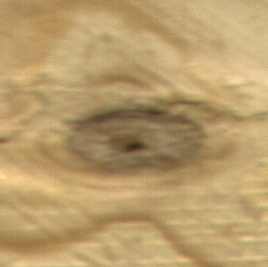

In [55]:
id = 1500
print(new_dataset[id]['image'].size)
print(new_dataset[id]['text'])
new_dataset[id]['image']

# Сохраняем датасет

In [59]:
from datasets import Dataset
path_to_save_dataset = '/app/dataset/promt_datasets_for_woods_defects_one_prompt'
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

dataset.save_to_disk(path_to_save_dataset) # Сохраним датасет на диск 

Saving the dataset (0/3 shards):   0%|          | 0/7324 [00:00<?, ? examples/s]

In [62]:
from datasets import Dataset

In [63]:
new_dataset = Dataset.load_from_disk(path_to_save_dataset)
len(new_dataset)

7324

(268, 267)
Live_Knot on a wooden surface


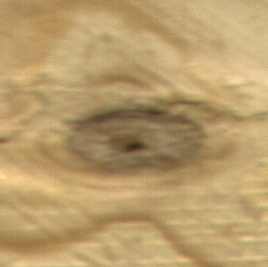

In [64]:
id = 1500
print(new_dataset[id]['image'].size)
print(new_dataset[id]['text'])
new_dataset[id]['image']

## Далее запускаем обучение на этом датасете в блокноте `augmentation_with_sd.ipynb`

